In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [15]:
class FuelConsumption:
    """Record fuel consumption of my Ford-Focus"""
    def __init__(self):
        self.df_data = pd.read_csv('bigfu_M_YX9587.csv', sep='\t')
        # Dates of change summer tires
        self.summer_tire = pd.to_datetime(
            pd.DataFrame({
                'year': [2016, 2017, 2018, 2019, 2020],
                'month': [4, 3, 4, 4, 4],
                'day': [1, 29, 3, 3, 16]
            }))
        # Dates of change winter tires
        self.winter_tire = pd.to_datetime(
            pd.DataFrame({
                'year': [2016, 2017, 2018, 2019],
                'month': [10, 11, 10, 9],
                'day': [12, 6, 19, 28]
            }))

        # Years
        self.y2016 = datetime.datetime(2016, 1, 1)
        self.y2017 = datetime.datetime(2017, 1, 1)
        self.y2018 = datetime.datetime(2018, 1, 1)
        self.y2019 = datetime.datetime(2019, 1, 1)
        self.y2020 = datetime.datetime(2020, 1, 1)

    def process_data(self):
        '''
        Sort according to date and kilometer status
        Calculate price/L, kilometer since last tank
        '''
        self.df_data.sort_values(['Datum', 'Laufleistung'], inplace=True)
        self.df_data['Datum'] = pd.to_datetime(self.df_data['Datum'])

        self.df_data['Preis'] = (self.df_data.Kosten /
                                 self.df_data.Tankmenge).round(3)

        self.df_data['Distanz'] = self.df_data['Laufleistung'].diff().fillna(
            0).astype(int)

    def fuel_consumption(self):
        '''Calculate fuel comsumption per 100 km'''
        self.df_data_ = self.df_data.copy()
        idx = self.df_data_[self.df_data_.ArtNr == 2].index

        for i in idx:
            self.df_data_.loc[i + 1, 'Distanz'] += self.df_data_.loc[i,
                                                                     'Distanz']
            self.df_data_.loc[i + 1,
                              'Tankmenge'] += self.df_data_.loc[i, 'Tankmenge']

        self.df_data_.drop(np.insert(idx, 0, 0), inplace=True)
        self.df_data_['Verbrauch'] = (self.df_data_.Tankmenge /
                                      self.df_data_.Distanz * 100).round(2)

    def print_info(self):
        print(
            "---------------------------------------------------------------------------------"
        )
        print("Annual Distance (km): ")
        print(
            self.df_data.groupby(pd.PeriodIndex(self.df_data.Datum, freq='A'),
                                 axis=0)['Distanz'].sum())
        print(
            "---------------------------------------------------------------------------------\n"
        )
        self.AvgConsp = sum(self.df_data.Tankmenge) / sum(
            self.df_data.Distanz) * 100
        print("Average fuel consumption is %.2f L/100km." % self.AvgConsp)
        print(
            "---------------------------------------------------------------------------------\n"
        )
        current_year = self.df_data.set_index('Datum')[self.y2020:]
        cost = current_year['Kosten'].sum()
        print("Fuel cost since 2020: {} \u20ac \n".format(round(cost, 2)))
        print(current_year)

        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.scatter(self.df_data.Datum, self.df_data.Preis, c='#F0C61B', marker='.')
        ax.plot(self.df_data.Datum, self.df_data.Preis, c='#F0C61B')
        ax.xaxis_date()
        ax.tick_params(axis='x', rotation=60, labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_xlabel("Date", fontsize=14)
        ax.set_ylabel("Fuel Price (\u20ac / L)", fontsize=14)
        ax.grid(b=None, which='major', axis='x')
        ax.set_title("Diesel Price", fontsize=16)

    def regression_model(self):
        '''Regression with SVM'''
        df_data = self.df_data_.set_index('Datum')
        X = (df_data.index - df_data.index[0]).days.values.reshape(-1, 1)
        sc = StandardScaler()
        X_std = sc.fit_transform(X)

        y = self.df_data_['Verbrauch'].values
        svr = SVR(kernel='rbf', C=1e2, gamma=2).fit(X_std, y)
        y_fit = svr.predict(X_std)

        fig = plt.figure(figsize=(10, 6))
        ax = plt.subplot(111)
        plt.plot(df_data.index, y_fit, label="Regression Model", color='r')
        plt.scatter(df_data.index, y, edgecolor='b', s=15, label="Data")
        plt.axhline(y=self.AvgConsp,
                    linestyle='--',
                    color='k',
                    alpha=0.6,
                    label="Average Consumption")
        # format
        xlabel = ax.get_xticks().tolist()
        ax.xaxis_date()
        plt.xticks(rotation=60, fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(loc="lower left")
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Fuel Consumption (L / 100km)", fontsize=14)
        for i in range(len(self.summer_tire)):
            plt.axvline(x=self.summer_tire[i],
                        linewidth=1,
                        color='y',
                        alpha=0.3,
                        label="Summer Tires")
        for i in range(len(self.winter_tire)):
            plt.axvline(x=self.winter_tire[i],
                        linewidth=1,
                        color='c',
                        alpha=0.3,
                        label="Winter Tires")

        plt.savefig('FuelConsumption.pdf', bbox_inches='tight', dpi=300)

---------------------------------------------------------------------------------
Annual Distance (km): 
Datum
2016    22587
2017    22543
2018    23894
2019    30438
2020    17226
Freq: A-DEC, Name: Distanz, dtype: int64
---------------------------------------------------------------------------------

Average fuel consumption is 5.11 L/100km.
---------------------------------------------------------------------------------

Fuel cost since 2020: 1015.91 € 

            ArtNr  Laufleistung  Tankmenge  Kosten  Preis  Distanz
Datum                                                             
2020-01-04      1        207715      38.33   48.64  1.269      773
2020-01-08      1        208309      31.38   40.10  1.278      594
2020-01-11      1        208898      33.68   42.07  1.249      589
2020-01-22      1        209546      33.57   40.59  1.209      648
2020-02-14      1        209894      20.99   25.60  1.220      348
2020-02-14      1        210419      32.25   38.67  1.199      525


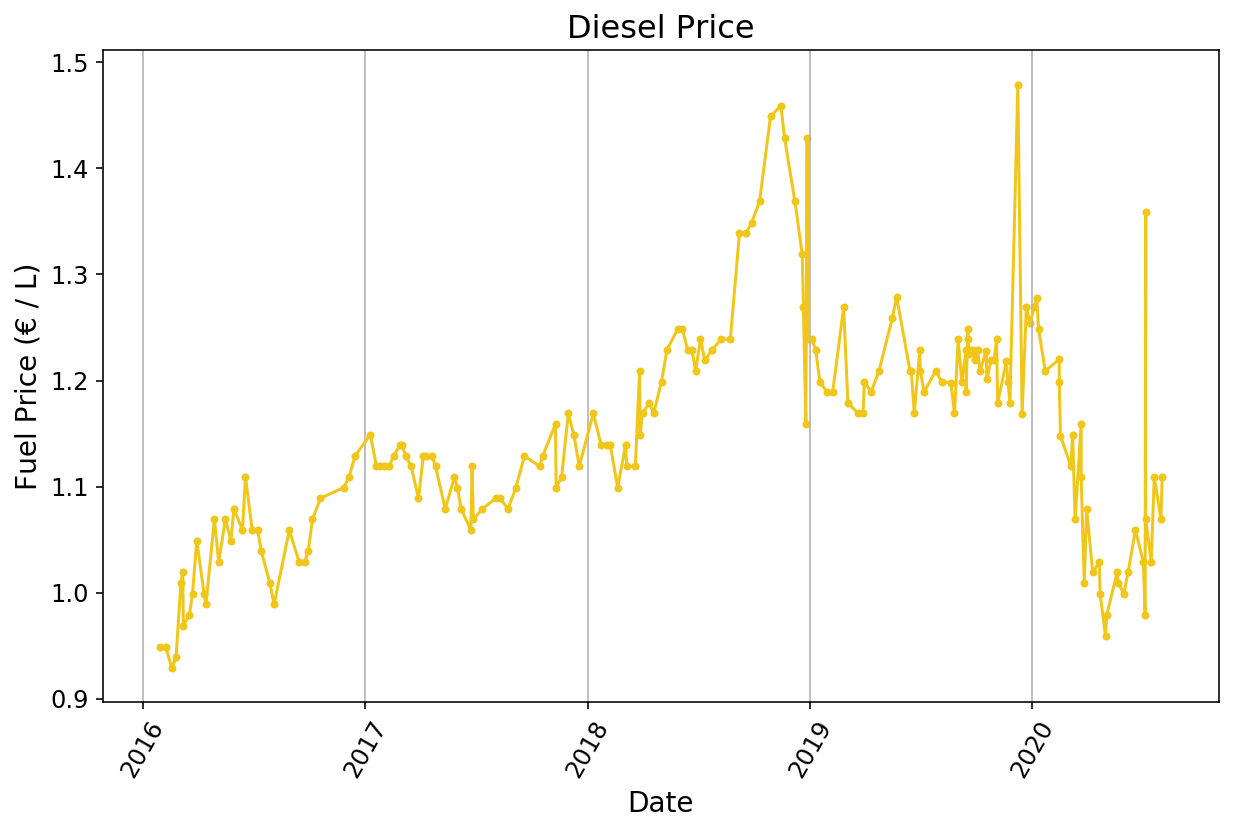

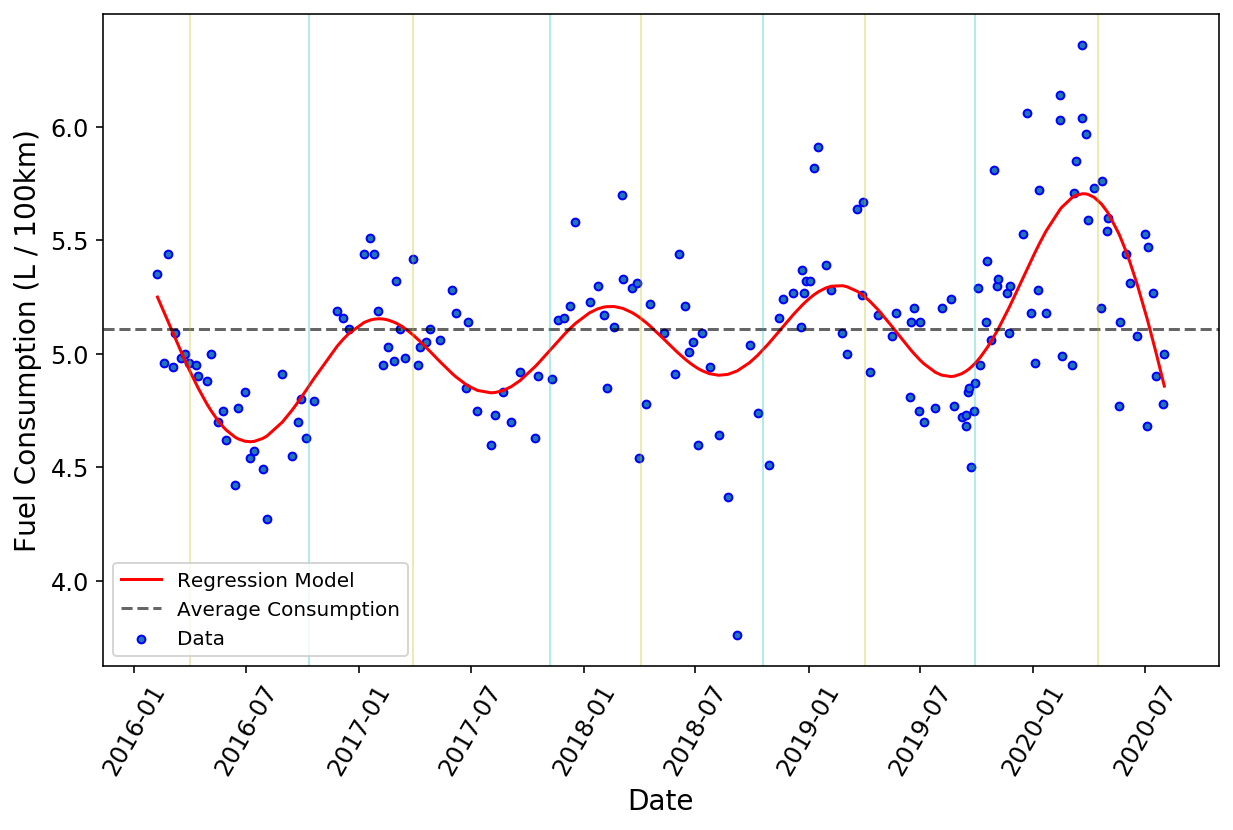

In [16]:
fc = FuelConsumption()
fc.process_data()
fc.fuel_consumption()
fc.print_info()
fc.regression_model()